In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
from mutation import *
from crossover import *
from rmp import *
from mfea import *
from task import *
from llm import *
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")

deepseek = DeepseekModel(DEEPSEEK_API_KEY, "deepseek-chat", 1.0)

In [20]:
gnbg_tasks = []
gnbg_tasks.append(GNBGTask(1))
gnbg_tasks.append(GNBGTask(2))

In [36]:
num_p = 10
dim = 30
p1 = np.random.uniform(-100, 100, size=(num_p, dim))
p2 = np.random.uniform(-100, 100, size=(num_p, dim))
p1_skill_factor = np.random.randint(0, 2, size=num_p)
p2_skill_factor = np.random.randint(0, 2, size=num_p)

In [4]:
tasks = []
tasks.append(GriewankTask())
tasks.append(RastriginTask())

In [5]:
num_indis_per_task = 200
indi_len = 50
bound = 100
crossover = BLXCrossover()
mutation = PolynomialMutation(20, bound)
rmp = AdaptiveRMP(rmp_pop_size=3, num_gen=1, pc=0.8, pm=0.1)
amfea = AMFEA(num_indis_per_task, indi_len, bound, tasks, crossover, mutation, rmp)

Initialization:
Task 0:
Best Fitness: 1000.842512952406
Mean Fitness: 1489.5849003982219

Task 1:
Best Fitness: 690.2298683179795
Mean Fitness: 926.1667752942739



In [ ]:
bfs, mfs = amfea.fit(5000, monitor=True, monitor_rate=200, llm_rate=1000)

Gen: 0
Creating 3 ideas
Creating code...
Better off count: 68
Performance: 0.6017699115044248
Creating code...
Better off count: 55
Performance: 0.48672566371681414
Creating code...
Better off count: 59
Performance: 0.5221238938053098
Crossover...
Creating code...
Better off count: 51
Performance: 0.45132743362831856
Reverse...
Creating code...
Better off count: 48
Performance: 0.4247787610619469
Gen 0
Time taken: 203.60 seconds

Gen: 1
Gen: 2
Gen: 3
Gen: 4
Gen: 5
Gen: 6
Gen: 7
Gen: 8
Gen: 9
Gen: 10
Gen: 11
Gen: 12
Gen: 13
Gen: 14
Gen: 15
Gen: 16
Gen: 17
Gen: 18
Gen: 19
Gen: 20
Gen: 21
Gen: 22
Gen: 23
Gen: 24
Gen: 25
Gen: 26
Gen: 27
Gen: 28
Gen: 29
Gen: 30
Gen: 31
Gen: 32
Gen: 33
Gen: 34
Gen: 35
Gen: 36
Gen: 37
Gen: 38
Gen: 39
Gen: 40
Gen: 41
Gen: 42
Gen: 43
Gen: 44
Gen: 45
Gen: 46
Gen: 47
Gen: 48
Gen: 49
Gen: 50
Gen 50
Time taken: 0.00 seconds

Gen: 51
Gen: 52
Gen: 53
Gen: 54
Gen: 55
Gen: 56
Gen: 57
Gen: 58
Gen: 59
Gen: 60
Gen: 61
Gen: 62
Gen: 63
Gen: 64
Gen: 65
Gen: 66
Gen: 67
Gen: 6

KeyboardInterrupt: 

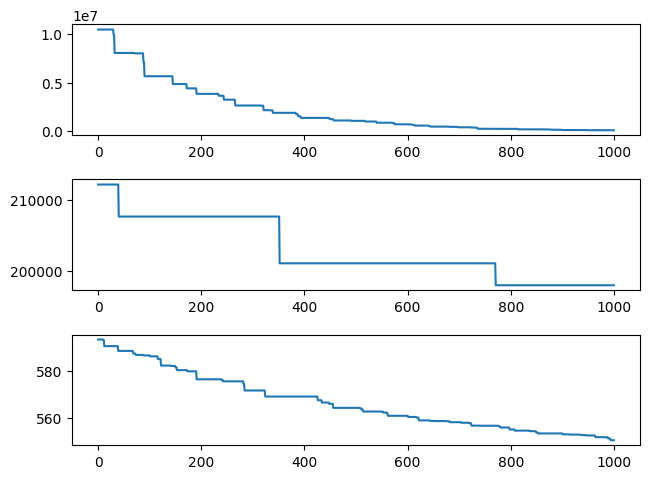

In [ ]:
num_tasks = len(tasks)
fig, axes = plt.subplots(num_tasks, 2)
fig.tight_layout()
for i in range(num_tasks):
    axes[i][0].plot(bfs[i])
    axes[i][1].plot(mfs[i])

In [3]:
ideas = deepseek.initial_ideas(3)

Creating 3 ideas


In [4]:
print(ideas[0])
print(ideas[1])
print(ideas[2])

Use a sigmoid-based RMP that adjusts based on the difference in skill factors, where parents with similar skill factors have higher RMP, but the fitness scores modulate the steepness of the sigmoid to allow more exploration when fitness differences are small.
Incorporate a dynamic thresholding mechanism where RMP is high if both parents belong to the same skill factor, but if they differ, the RMP decays exponentially with the absolute difference in fitness, scaled by the ratio of their skill factors.
Design a hybrid RMP that combines a base probability (from skill factor similarity) with a perturbation term derived from the normalized fitness ratio, ensuring that even dissimilar parents can mate if their fitness scores are highly complementary.


In [5]:
code = deepseek.idea_to_code_function(ideas[0])
print(code)

def get_rmp(p1, p2, p1_skill_factor, p2_skill_factor, p1_fitness, p2_fitness):  
    skill_diff = np.abs(p1_skill_factor - p2_skill_factor)  
    normalized_skill_diff = skill_diff / np.max(skill_diff + 1e-10)  
    fitness_diff = np.abs(p1_fitness - p2_fitness)  
    normalized_fitness_diff = fitness_diff / (np.max(fitness_diff) + 1e-10)  
    steepness = 10.0 * (1.0 - normalized_fitness_diff)  
    rmp = 1.0 / (1.0 + np.exp(steepness * (normalized_skill_diff - 0.5)))  
    return rmp
